# Installing Dependencies of latest versions

In [2]:
! pip install -U accelerate
! pip install -U transformers
!pip install datasets

# Importing the Libraries

In [3]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging
from datasets import Dataset


# Fine Tuning with PreTrained Model

In [41]:
pretrained_model = "distilbert-base-uncased"
# pretrained_model = "bert-base-uncased"

# Setting up Dataset for Training and Testing

In [42]:
def import_data(csv_file):
    """
    Import and structuring the DataFrame
    Parameter: Csv_File
    Output: CsvFile transformed version
    """
    df = pd.read_csv(csv_file) # Reading the CSV
    df['text'] = 'Title:' + df['Title'] + ' Description' + df['Description']  # Combining 2 Text Columns
    df.rename(columns = {'Class Index': 'label'}, inplace = True) # Renamed Target as Label
    df['label'].replace({4:0}, inplace = True) # Rephasing the Target to be from 0-3
    df.drop(['Title', 'Description'], axis = 1, inplace = True) # Dropping redundency Column

    return df

In [6]:
# !unzip train.csv.zip
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


# Parsing the CSV Data to PreProcess Pipeline

In [48]:
# Reading the Test Data and since it requires huge time for training,
# Made only 200 records for Training and 50 Records for Testing
data = pd.read_csv('test.csv')
first_200_Train = data.head(200)
last_50_Test = data.tail(50)

In [49]:
# Storing the CSVs
first_200_Train.to_csv('first_200_Train.csv')
last_50_Test.to_csv('last_50_Test.csv')

In [62]:
train_df = import_data('/content/first_200_Train.csv')

In [63]:
try:
  train_df.drop(columns=['Unnamed: 0'], inplace=True)
except:
  pass
train_df.head() # Reading first 5 records

,label,text
0,3,Title:Fears for T N pension after talks Descri...
1,0,Title:The Race is On: Second Private Team Sets...
2,0,Title:Ky. Company Wins Grant to Study Peptides...
3,0,Title:Prediction Unit Helps Forecast Wildfires...
4,0,Title:Calif. Aims to Limit Farm-Related Smog (...


# Using NLTK for Cleaning the Text

In [15]:
# Downloading necessary Files from NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
# Importing NLTK Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join tokens back into a single string
    text = ' '.join(tokens)

    return text


In [64]:
# Running the DataFrame through Pre Process Pipeline
train_df['clean_text'] = train_df['text'].apply(lambda x: preprocess_text(x))


In [65]:
train_df.head() # First 5 records after cleaning.

,label,text,clean_text
0,3,Title:Fears for T N pension after talks Descri...,titlefear n pension talk descriptionunion repr...
1,0,Title:The Race is On: Second Private Team Sets...,titleth race second privat team set launch dat...
2,0,Title:Ky. Company Wins Grant to Study Peptides...,titleki compani win grant studi peptid ap desc...
3,0,Title:Prediction Unit Helps Forecast Wildfires...,titlepredict unit help forecast wildfir ap des...
4,0,Title:Calif. Aims to Limit Farm-Related Smog (...,titlecalif aim limit farmrel smog ap descripti...


In [68]:
# Splitting the Dataset into Train and Val by keeping 80% for Training and 20 % for testing

train_df, val_df = train_test_split(train_val_df[['clean_text', 'label','text']],
                                    test_size = 0.2, random_state = 42)



In [69]:
train_df.head()

,clean_text,label,text
79,titlel olymp day four descriptionrichard fauld...,1,Title:Live: Olympics day four DescriptionRicha...
197,titletoday athen descriptionleontien zijlaardv...,2,Title:Today in Athens DescriptionLeontien Zijl...
38,titleiran warn missil hit anywher israel descr...,1,Title:Iran Warns Its Missiles Can Hit Anywhere...
24,titleriv tri turn tabl charl schwab descriptio...,0,Title:Rivals Try to Turn Tables on Charles Sch...
122,titleamd ship notebook chip descriptionit firs...,0,Title:AMD Ships Notebook Chips DescriptionIt w...


In [70]:
train_df.shape # Shape of final Train Data

(160, 3)

# Checking the Label distrubution

In [71]:
train_df.label.value_counts()

1    51
0    48
2    36
3    25
Name: label, dtype: int64

In [72]:
val_df.label.value_counts()

2    17
1    10
0     9
3     4
Name: label, dtype: int64

# Converting the data as per model requirement

In [73]:
# Tokenize the text
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

def preprocess_function(examples):
    """
    Using Transformer Tokenizer to Tokenize the text
    """
    return tokenizer(examples["text"], truncation=True)


def pipeline(dataframe):
    """
    DataFrame Transformation to Tokenized Dataset (columns = text, label, input, attention)
    """
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [74]:
train_df.head()

,clean_text,label,text
79,titlel olymp day four descriptionrichard fauld...,1,Title:Live: Olympics day four DescriptionRicha...
197,titletoday athen descriptionleontien zijlaardv...,2,Title:Today in Athens DescriptionLeontien Zijl...
38,titleiran warn missil hit anywher israel descr...,1,Title:Iran Warns Its Missiles Can Hit Anywhere...
24,titleriv tri turn tabl charl schwab descriptio...,0,Title:Rivals Try to Turn Tables on Charles Sch...
122,titleamd ship notebook chip descriptionit firs...,0,Title:AMD Ships Notebook Chips DescriptionIt w...


In [75]:
tokenized_train = pipeline(train_df)
tokenized_val = pipeline(val_df)

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

# Setting up Model Hyper Parameters

In [76]:
# Set values for model and train
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=4)

training_args = TrainingArguments(
    output_dir="./results",
    # important as the standard setting of 500 creates too much data
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    report_to="none", # Stops transformers from trying to connect to weights and biases site
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [77]:
%time trainer.train()

Step,Training Loss


CPU times: user 18min 18s, sys: 27.7 s, total: 18min 45s
Wall time: 20min 58s


TrainOutput(global_step=150, training_loss=0.44342824300130207, metrics={'train_runtime': 1258.0564, 'train_samples_per_second': 1.908, 'train_steps_per_second': 0.119, 'total_flos': 81383421055104.0, 'train_loss': 0.44342824300130207, 'epoch': 15.0})

# Testing the model

In [80]:
train_df.head()

,clean_text,label,text
79,titlel olymp day four descriptionrichard fauld...,1,Title:Live: Olympics day four DescriptionRicha...
197,titletoday athen descriptionleontien zijlaardv...,2,Title:Today in Athens DescriptionLeontien Zijl...
38,titleiran warn missil hit anywher israel descr...,1,Title:Iran Warns Its Missiles Can Hit Anywhere...
24,titleriv tri turn tabl charl schwab descriptio...,0,Title:Rivals Try to Turn Tables on Charles Sch...
122,titleamd ship notebook chip descriptionit firs...,0,Title:AMD Ships Notebook Chips DescriptionIt w...


In [81]:
test_df.head()

,label,text,clean_text
0,2,Robinho #39;s mother releaased by kidnappers T...,robinho mother releaas kidnapp mother santo st...
1,2,"Coulthard secures Red Bull seat Coulthard, who...",coulthard secur red bull seat coulthard whose ...
2,1,Bosnian Serb PM resigns after war crimes criti...,bosnian serb pm resign war crime critic afp af...
3,3,November Consumer Prices Rise Moderately US co...,novemb consum price rise moder us consum price...
4,3,United Pilots Cut Deal on Pensions United Airl...,unit pilot cut deal pension unit airlin pilot ...


In [82]:
test_df = import_data('/content/last_50_Test.csv')
test_df['clean_text'] = test_df['text'].apply(lambda x: preprocess_text(x))

tokenized_test = pipeline(test_df)

tokenized_test = tokenized_test.remove_columns('label')

preds = trainer.predict(tokenized_test)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [83]:
preds_flat = [np.argmax(x) for x in preds[0]]

len(preds_flat)

50

# Metrics

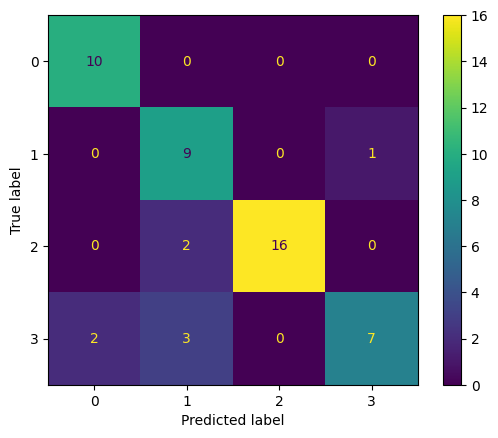

In [84]:
cm = confusion_matrix(test_df['label'], preds_flat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

In [85]:
precision, recall, fscore, support = score(test_df['label'], preds_flat)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.83333333 0.64285714 1.         0.875     ]
recall: [1.         0.9        0.88888889 0.58333333]
fscore: [0.90909091 0.75       0.94117647 0.7       ]
support: [10 10 18 12]
